In [1]:
import numpy as np
import pandas as pd
import scipy as scp
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cmx
from src.mssm.models import *
np.set_printoptions(suppress=True)

nc = 10
colors = [cmx.tab20(x) for x in np.linspace(0.0,min(0.1*nc,1.0),nc)]

## Data structure

In [2]:
# Import some simulated data
dat = pd.read_csv("./data/GAMM/sim_dat.csv")

# mssm requires that the data-type for variables used as factors is 'O'=object
dat = dat.astype({'series': 'O',
                  'cond':'O',
                  'sub':'O',
                  'series':'O'})

Some remarks about the desired layout of the data to be usable with the GAMM class:
- The dependent variable can contain NAs, which will be taken care of. No NAs should be present in any of the predictor columns!
- We need an identifier of individual series. In this dataframe that is the variable 'series'. Usually a series is an individual trial - but if there are multiple conditions and the same trial values are used accross conditions the series identifier is actually the interaction of condition and trial.
- The data-type (dtype) for numeric columns should be float or int. Categorical predictors need to have the object datatype (see code above).
- No specific row/column sorting is required.

In [3]:
# Take a look at the data:
dat.head()

,y,time,series,cond,sub,x
0,7.005558,0,0,a,0,9.817736
1,11.122316,20,0,a,0,10.262371
2,4.766720,40,0,a,0,10.445887
3,2.952046,60,0,a,0,8.481554
4,7.463034,80,0,a,0,10.180660


## Building GAMMs

### Getting started!

We can build a broad variety of GAMMs as they are also supported in mgcv (Wood, 2017). Smooths that are available in mgcv and are also supported here include regular univariate smooths, binary smooth terms, Tensor smooth interactions, by-factor smooths, and random non-linear smooths. mssm also supports random effects (random intercepts, random slopes, and as mentioned random smooths).

A B-spline basis is used by mssm and penalties are either difference (Eilers & Marx, 2010) or identity penalties (Null-space penalties, Marra & Wood (2012) are also supported). Currently, Binomial models (N >= 1) and Gaussian models are supported!

In [4]:
# Build a simple GAMM
# y = a + f(time) + e with e ~ N(0,sigma)
formula = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               f(["time"])], # The f(time) term, by default parameterized with 9 basis functions (after absorbing one for identifiability)
                        series_id = "series",
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:605: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.get_lhs().variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [5]:
# Initialize the GAMM as a Gaussian one, i.e., Pupil ~ N(a + f(time),sigma)
model = GAMM(formula,Gaussian())

In [6]:
# Some info about the size of this model:
print(f"Model will estimate {model.formula.n_coef} coefficients from {len(model.formula.y_flat[model.formula.NOT_NA_flat])} datapoints!")

Model will estimate 10 coefficients from 29217 datapoints!


In [7]:
# Fit the model
model.fit()

NAs were excluded for fitting.


In [8]:
# Get predictions and parameter estimates
coef, sigma = model.get_pars() # Coef = weights for basis functions, sigma = **variance** of residuals!
pred = model.pred # The model prediction for the entire data, here: a + f(Time)!
res = model.res # The residuals
y = model.formula.y_flat[model.formula.NOT_NA_flat] # The dependent variable after NAs were removed

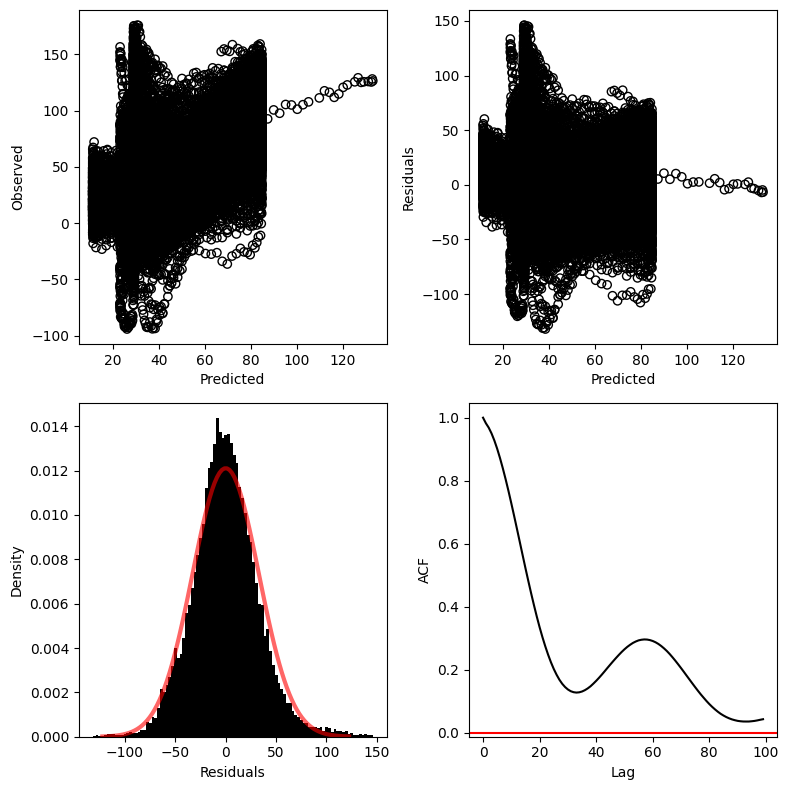

In [9]:
# Check model performance
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.scatter(pred,y,color="black",facecolor='none')
plt.xlabel("Predicted")
plt.ylabel("Observed")


plt.subplot(2,2,2)
plt.scatter(pred,res,color="black",facecolor='none')
plt.xlabel("Predicted")
plt.ylabel("Residuals")


plt.subplot(2,2,3)
plt.hist(res,bins=100,density=True,color="black")
x = np.linspace(scp.stats.norm.ppf(0.0001,scale=math.sqrt(sigma)),
                scp.stats.norm.ppf(0.9999,scale=math.sqrt(sigma)), 100)

plt.plot(x, scp.stats.norm.pdf(x,scale=math.sqrt(sigma)),
        'r-', lw=3, alpha=0.6)
plt.xlabel("Residuals")
plt.ylabel("Density")

# Auto-correlation check
lag = 100
cc = np.vstack([res[:-lag,0],*[res[l:-(lag-l),0] for l in range(1,lag)]]).T
acf = [np.corrcoef(cc[:,0],cc[:,l])[0,1] for l in range(lag)]

plt.subplot(2,2,4)
plt.plot(range(lag),acf,color="black")
plt.axhline(0,color="red")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.tight_layout()
plt.show()

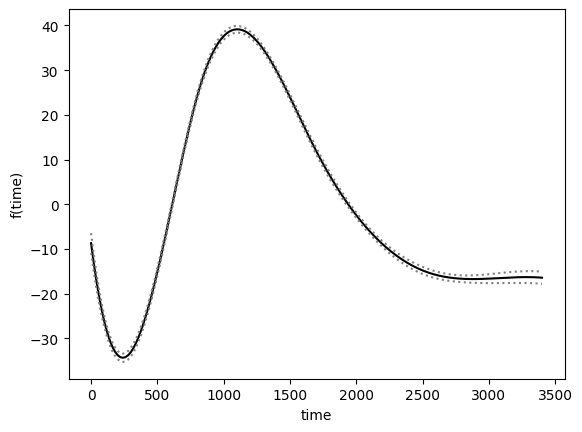

In [10]:
# Partial prediction for a single smooth
time_pred = [t for t in range(0,3420,20)]
new_dat = pd.DataFrame({"time":time_pred,
                        "series":["0" for _ in range(len(time_pred))]})

# Make partial prediction using just terms[1] - the smooth of time or f(time)!
pred,pred_mat,boundary = model.predict([1],new_dat,ci=True,alpha=0.05)

plt.plot(time_pred,pred,color='black')
plt.plot(time_pred,pred + boundary,color='grey', linestyle='dotted')
plt.plot(time_pred,pred - boundary,color='grey', linestyle='dotted')
plt.xlabel("time")
plt.ylabel("f(time)")
plt.show()

### A by-condition GAM

To get a by-factor model (s(Time,by=cond) in mgcv) mssm also provides a by keyword!

In [11]:
# y = a + b1*c1 + f0(time) + f1(time) + e
# with e ~ N(0,sigma) and c1 == 1 if cond == "b" else 0
# and f0() and f1() representing the smooths over time for
# the first (a) and second (b) level of cond respectively.
formula2 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # One coefficient per dummy-predictor necessary for factor cond - here b1
                               f(["time"],by="cond")], # One f(time) term for every level of cond
                        series_id = "series",
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:605: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.get_lhs().variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [12]:
# Fit the model
model2 = GAMM(formula2,Gaussian())
model2.fit()

NAs were excluded for fitting.


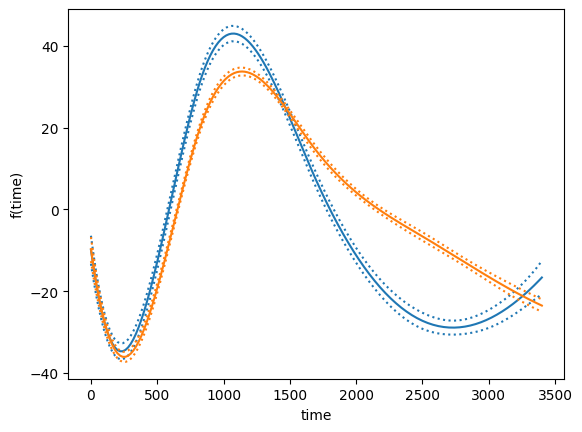

In [13]:
# Partial prediction (using only the f(time)) for all conditions
# Basically what plot(model) does in R in case model was obtained from mgcv

for ci,c in enumerate(["a","b"]):
    # Set up some new data for prediction
    time_pred = [t for t in range(0,3420,20)]
    
    new_dat = pd.DataFrame({"cond":[c for _ in range(len(time_pred))],
                            "time":time_pred,
                            "series":["0" for _ in range(len(time_pred))]})
    
    # Make prediction using only the correct f(time) for every condition
    pred,_,b = model2.predict([2],new_dat,ci=True,alpha=0.05)
    plt.plot(time_pred,pred,color=colors[ci])
    plt.plot(time_pred,pred+b,color=colors[ci], linestyle='dotted')
    plt.plot(time_pred,pred-b,color=colors[ci], linestyle='dotted')

plt.xlabel("time")
plt.ylabel("f(time)")
plt.show()

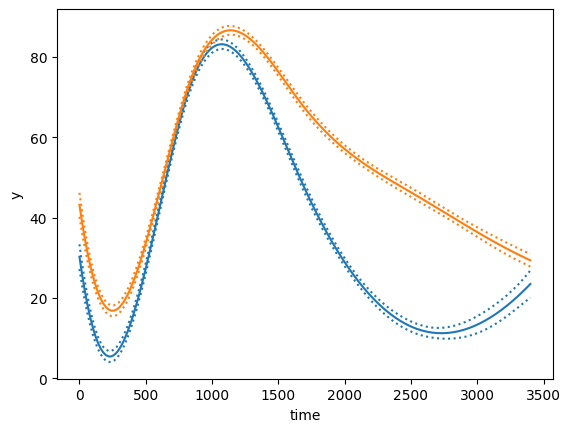

In [14]:
# Fixed prediction (using not only the f(time) but also a and b1!) for all conditions
# Basically the model prediction per condition.
# Note how the y-axis changes but not the shape of the smooths!

for ci,c in enumerate(["a","b"]):
    # Set up some new data for prediction
    time_pred = [t for t in range(0,3420,20)]
    
    new_dat = pd.DataFrame({"cond":[c for _ in range(len(time_pred))],
                            "time":time_pred,
                            "series":["0" for _ in range(len(time_pred))]})
    
    # Make prediction using all terms in the model - set the first argument to None
    pred,_,b = model2.predict(None,new_dat,ci=True,alpha=0.05)
    plt.plot(time_pred,pred,color=colors[ci])
    plt.plot(time_pred,pred+b,color=colors[ci], linestyle='dotted')
    plt.plot(time_pred,pred-b,color=colors[ci], linestyle='dotted')

plt.xlabel("time")
plt.ylabel("y")
plt.show()

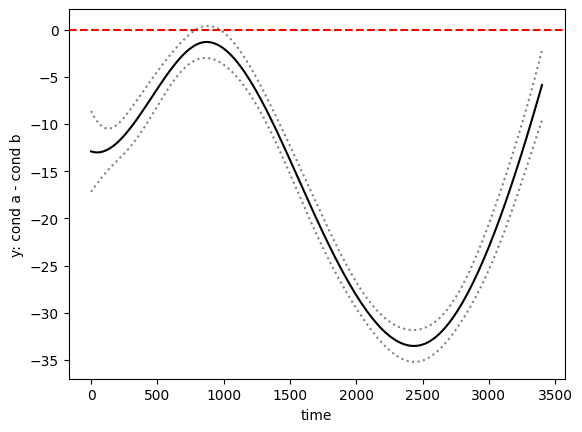

In [15]:
# Difference predictions between two conditions!
# Allows us to plot the predicted difference over time between conditions a and b.
# This is basically the difference between the two curves shown in the last plot -
# so the offset differences induced by a and b1 are taken into account!!
time_pred = [t for t in range(0,3420,20)]
new_dat1 = pd.DataFrame({"cond":["a" for _ in range(len(time_pred))],
                         "time":time_pred,
                         "series":["0" for _ in range(len(time_pred))]})

new_dat2 = pd.DataFrame({"cond":["b" for _ in range(len(time_pred))],
                         "time":time_pred,
                         "series":["0" for _ in range(len(time_pred))]})

diff,b = model2.predict_diff(new_dat1,new_dat2,None)

plt.plot(time_pred,diff,color='black')
plt.plot(time_pred,diff + b,color='grey', linestyle='dotted')
plt.plot(time_pred,diff - b,color='grey', linestyle='dotted')
plt.axhline(0,color="red",linestyle="dashed")
plt.xlabel("time")
plt.ylabel("y: cond a - cond b")
plt.show()

### A binary smooth model
If the difference between conditions is of interest it might be more desirable to fit a difference curve for specific levels of the factor of interest.
Such a model is set up below!

In [16]:
formula3 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               f(["time"]), # One f(time) term - will correspond to the baseline level for condition: here let's choose b
                               f(["time"],binary=["cond","a"])], # Another f(time), this one models the difference over time from the other f(time) term for cond=a!
                        series_id = "series",
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:605: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.get_lhs().variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [17]:
# Fit the model
model3 = GAMM(formula3,Gaussian())
model3.fit()

NAs were excluded for fitting.


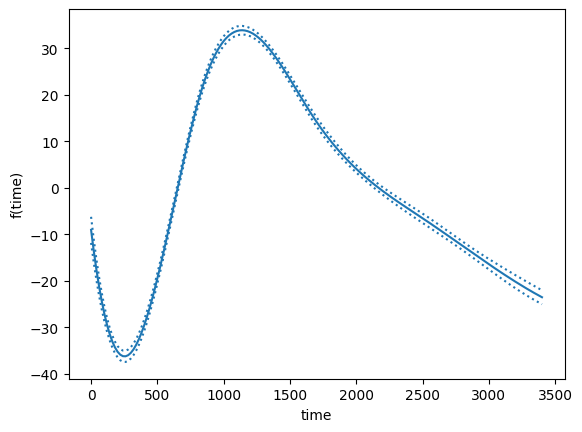

In [18]:
# Let's look at just the f(time) for level a - this one looks just like before!
time_pred = [t for t in range(0,3420,20)]

new_dat = pd.DataFrame({"cond":["b" for _ in range(len(time_pred))],
                        "time":time_pred,
                        "series":["0" for _ in range(len(time_pred))]})

# Make prediction using just the first f(time) term!
pred,_,b = model3.predict([1],new_dat,ci=True,alpha=0.05)
plt.plot(time_pred,pred,color=colors[0])
plt.plot(time_pred,pred+b,color=colors[0], linestyle='dotted')
plt.plot(time_pred,pred-b,color=colors[0], linestyle='dotted')

plt.xlabel("time")
plt.ylabel("f(time)")
plt.show()

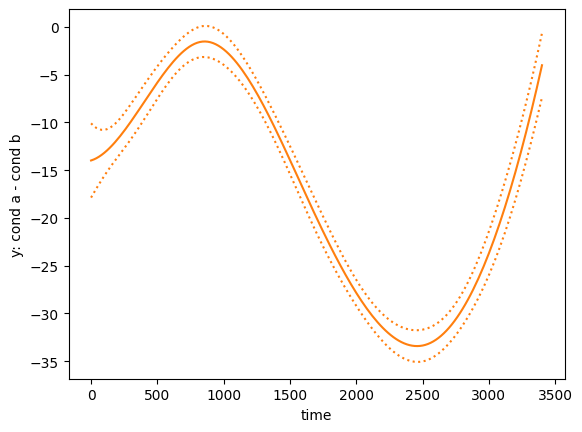

In [19]:
# However, just the prediction from the second f(time) does look very different
# now! In fact it represents the difference between the two conditions again!
time_pred = [t for t in range(0,3420,20)]

new_dat = pd.DataFrame({"cond":["a" for _ in range(len(time_pred))],
                        "time":time_pred,
                        "series":["0" for _ in range(len(time_pred))]})

# Make prediction using just the first f(time) term!
pred,_,b = model3.predict([2],new_dat,ci=True,alpha=0.05)
plt.plot(time_pred,pred,color=colors[1])
plt.plot(time_pred,pred+b,color=colors[1], linestyle='dotted')
plt.plot(time_pred,pred-b,color=colors[1], linestyle='dotted')

plt.xlabel("time")
plt.ylabel("y: cond a - cond b")
plt.show()

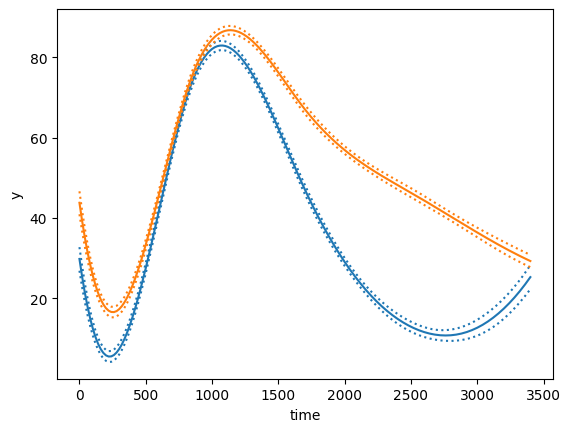

In [20]:
# If we use all terms we can still predict how y changes over time for both conditions:
for ci,c in enumerate(["a","b"]):
    # Set up some new data for prediction
    time_pred = [t for t in range(0,3420,20)]
    
    new_dat = pd.DataFrame({"cond":[c for _ in range(len(time_pred))],
                            "time":time_pred,
                            "series":["0" for _ in range(len(time_pred))]})
    
    # Make prediction using all terms in the model - set the first argument to None
    pred,_,b = model3.predict(None,new_dat,ci=True,alpha=0.05)
    plt.plot(time_pred,pred,color=colors[ci])
    plt.plot(time_pred,pred+b,color=colors[ci], linestyle='dotted')
    plt.plot(time_pred,pred-b,color=colors[ci], linestyle='dotted')

plt.xlabel("time")
plt.ylabel("y")
plt.show()

### Tensor smooth interactions

Non-linear interactions between continuous variables are supported via tensor smooth interactions (see Wood, 2017). Currently, only the behavior achieved by the ti() terms in mgcv is supported.

In [21]:
formula4 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # Offset for cond='b'
                               f(["time"],by="cond"), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond")], # one smooth surface over time and x - f(time,x) - per level of cond: three-way interaction!
                        series_id = "series",
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:605: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.get_lhs().variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [22]:
# Fit the model
model4 = GAMM(formula4,Gaussian())
model4.fit()

NAs were excluded for fitting.


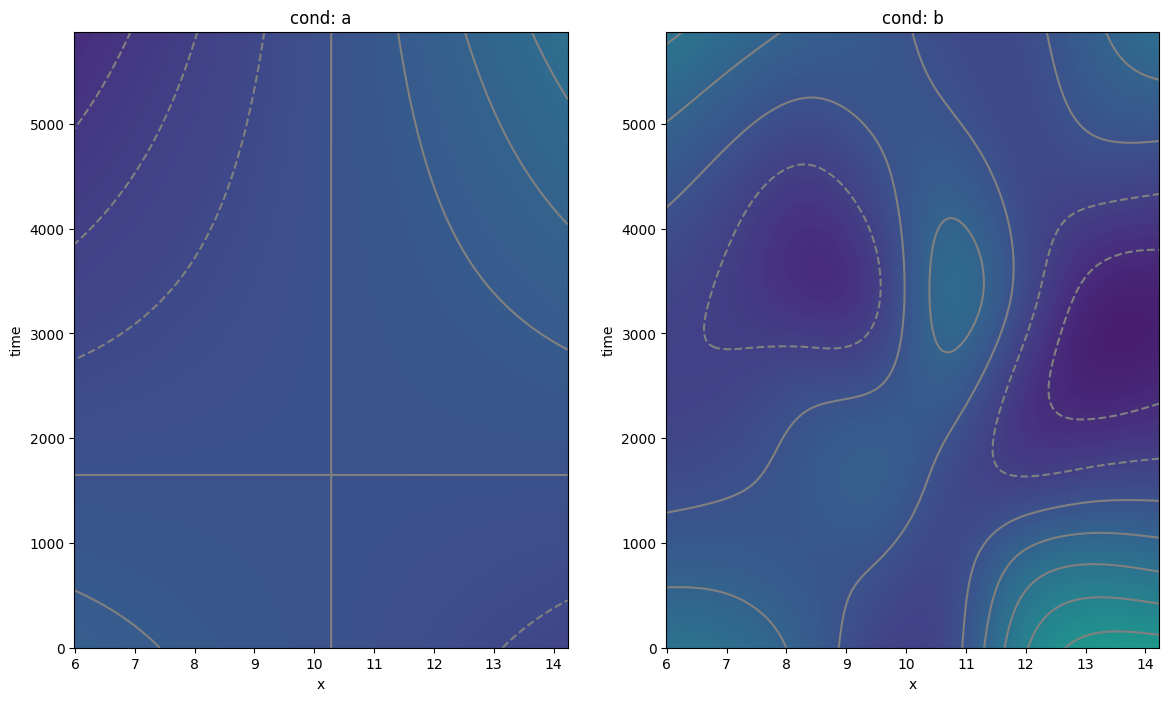

In [23]:
# Visualizing the partial interaction
fig = plt.figure(figsize=(14,8))

for ci,c in enumerate(["a","b"]):
    time_pred = []
    x_pred = []

    xr = [t for t in np.linspace(min(dat["x"]),max(dat["x"]),200)]
    tr = np.linspace(0,max(dat["time"]),len(xr))

    for t in tr:
        for x in xr:
            time_pred.append(t)
            x_pred.append(x)

    new_dat = pd.DataFrame({"x":x_pred,
                            "cond":[c for _ in range(len(x_pred))],
                            "time":time_pred,
                            "series":["0" for _ in range(len(x_pred))]})

    TP_pred,_,_ = model4.predict([4],new_dat)

    ax = fig.add_subplot(1,2,ci+1) #projection='3d'

    #ax.view_init(elev=25, azim=-10)
    #ax.scatter(freq_pred, time_pred, TP_pred, c = TP_pred, s = 1)

    ff = ax.contourf(xr,tr,TP_pred.reshape(len(xr),len(xr)),levels=len(xr),vmin=-2,vmax=6)
    ll = ax.contour(xr,tr,TP_pred.reshape(len(xr),len(xr)),colors="grey")
    ax.set_xlim((min(dat["x"]),max(dat["x"])))
    ax.set_title(f"cond: {c}")
    ax.set_ylabel("time")
    ax.set_xlabel("x")

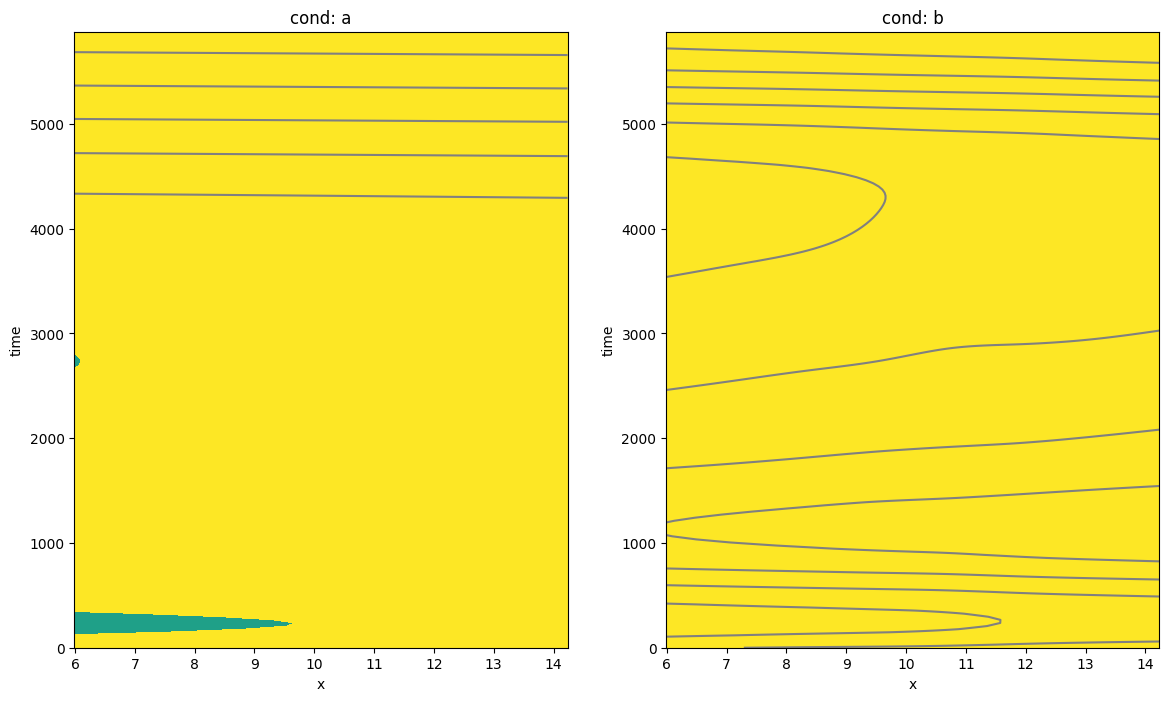

In [24]:
# Visualizing the fitted effect for both conditions
fig = plt.figure(figsize=(14,8))

for ci,c in enumerate(["a","b"]):
    time_pred = []
    x_pred = []

    xr = [t for t in np.linspace(min(dat["x"]),max(dat["x"]),200)]
    tr = np.linspace(0,max(dat["time"]),len(xr))

    for t in tr:
        for x in xr:
            time_pred.append(t)
            x_pred.append(x)

    new_dat = pd.DataFrame({"x":x_pred,
                            "cond":[c for _ in range(len(x_pred))],
                            "time":time_pred,
                            "series":["0" for _ in range(len(x_pred))]})

    TP_pred,_,_ = model4.predict(None,new_dat)

    ax = fig.add_subplot(1,2,ci+1)

    ff = ax.contourf(xr,tr,TP_pred.reshape(len(xr),len(xr)),levels=len(xr),vmin=-2,vmax=6)
    ll = ax.contour(xr,tr,TP_pred.reshape(len(xr),len(xr)),colors="grey")
    ax.set_xlim((min(dat["x"]),max(dat["x"])))
    ax.set_title(f"cond: {c}")
    ax.set_ylabel("time")
    ax.set_xlabel("x")

### Random effects
We can also include random intercepts, random slopes, and non-linear random effects - here we show an example of the latter.

In [25]:
formula5 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond"), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond"), # one smooth surface over time and x - f(time,x) - per level of cond: three-way interaction!
                               fs(["time"],rf="sub")], # Random non-linear effect of time - one smooth per level of factor sub
                        series_id = "series",
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:605: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.get_lhs().variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [26]:
# Fit the model
model5 = GAMM(formula5,Gaussian())
model5.fit()

NAs were excluded for fitting.


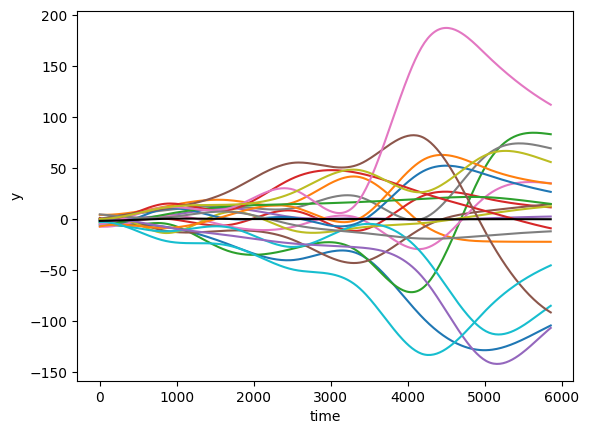

In [27]:
# Subject difference smooths - is there a subject-specific difference from the general trend?
subs = np.unique(dat["sub"])

avg_pred = None
for sub in subs:
    # Set up some new data for prediction
    time_pred = [t for t in range(0,max(dat["time"]),20)]
    new_dat = pd.DataFrame({"cond":["a" for _ in range(len(time_pred))],
                            "time":time_pred,
                            "sub":[sub for _ in range(len(time_pred))],
                            "x":[1 for _ in range(len(time_pred))],
                            "series":["0" for _ in range(len(time_pred))]})
    
    # Make prediction using random smooth terms only
    pred,_,_ = model5.predict([5],new_dat)
    if avg_pred is None:
        avg_pred = pred
    else:
        avg_pred += pred
    plt.plot(time_pred,pred)

plt.plot(time_pred,avg_pred/len(subs),color="black")
plt.xlabel("time")
plt.ylabel("y")
plt.show()